In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Environment:
    def __init__(self) -> None:
        self.state = 0
        self.terminated = False

    def reset(self):
        self.state = 0
        self.terminated = True

    def new_ep(self):
        self.terminated = False

    def get_state(self):
        return self.state

    def get_reward(self, action):
        if self.state == 0:
            reward = 0
        elif self.state == 1:
            rewards = [4,0]
            reward = rewards[action]
        elif self.state == 2:
            rewards = [2,3]
            reward = rewards[action]
        return reward

    def take_step(self,  action):
        self.terminated = False
        reward = self.get_reward(action)
        if self.state == 0:
            self.state = self.state + 1 + action
        else:
            # there is no further state
            self.reset()
        return reward



class Agent:
    def __init__(self, env, epsilon_a=0.075, policy_type="random", epsilon_c=0.2, decay=0, beta=1) -> None:
        self.vs = np.zeros(3)
        self.ms = [[0, 0], [0, 0], [0, 0]]
        self.policy = [[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]
        self.policy_type = policy_type
        self.env = env
        self.epsilon_a = epsilon_a
        self.epsilon_c = epsilon_c
        self.decay = decay
        self.beta = beta

    def reset_agent(self):
        # reset at the start of a new epoch
        self.vs = np.zeros(3)
        self.ms = [[0, 0], [0, 0], [0, 0]]
        self.policy = [[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]

    def critic(self):
        return self.vs

    def actor(self):
        #state = env.state
        action = np.random.choice(np.arange(2), p=self.policy[state])
        return action

    def update_policy(self, state, reward, new_state, action):
        if state == 0:
            delta = reward + self.vs[new_state] - self.vs[state]
        else:
            delta = reward - self.vs[state]
        for a in range(len(self.ms[state])):
            self.ms[state][a] = (1 - self.decay) * self.ms[state][a] + self.epsilon_a * self.delta_func(action, a) * delta
            self.policy[state] = self.softmax(self.ms[state])
        return self.policy

    def update_weights(self, reward, state, new_state):
        if state == 0:
            delta = reward + self.vs[new_state] - self.vs[state]
        else:
            delta = reward - self.vs[state]

        self.vs[state] += self.epsilon_c * delta

        return self.vs

    def softmax(self, x):
        for i in range(len(x)):
            x[i] = self.beta * x[i]
        return np.exp(x) / np.exp(x).sum()

    def delta_func(self, a, b):
        return a == b


# policy evaluation for "maze" environment
episodes = 1000
epochs = 1000
epsilon = 0.1

env_maze = Environment()
agent_maze = Agent(env=env_maze, epsilon_a=epsilon, policy_type="actor_critic")
v_over_epochs_pe_maze = np.zeros((epochs, episodes, 3))
for epoch in range(epochs):
    agent_maze.reset_agent()

    for episode in range(episodes):
        for step in range(2):
            if env_maze.terminated == False:
                state = env_maze.get_state()
                vs = agent_maze.critic()
                action = agent_maze.actor()
                reward = env_maze.take_step(action)
                new_state = env_maze.get_state()
                agent_maze.update_weights(reward, state, new_state)

        v_over_epochs_pe_maze[epoch, episode] = vs
        env_maze.new_ep()



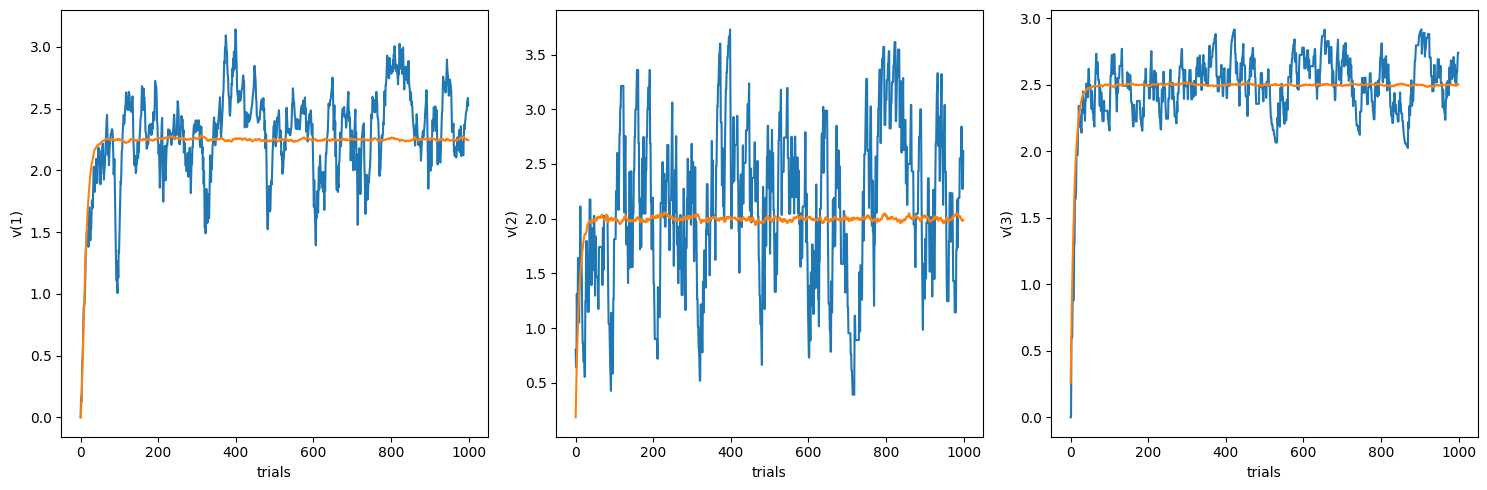

In [2]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figsize as needed

# Loop through each action and plot on the corresponding subplot
for action in range(3):
    means = np.mean(v_over_epochs_pe_maze[:, :, action], axis=0)

    # Plot the original data
    axes[action].plot(range(epochs), v_over_epochs_pe_maze[0, :, action], label=f'Action {action + 1}')

    # Plot the mean values
    axes[action].plot(range(epochs), means, label='Mean')

    # Set labels for the subplot
    axes[action].set_xlabel("trials")
    axes[action].set_ylabel(f"v({action + 1})")

   

# Adjust layout to prevent subplot labels from overlapping
plt.tight_layout()

# Show the plots
plt.show()

In [3]:

# policy evaluation for "maze" environment
trials = 1000
epochs = 1000
epsilon = 0.1

env_maze = Environment()
agent_maze = Agent(env=env_maze, epsilon_a=epsilon, epsilon_c = 0.2, policy_type="actor_critic")
v_hist = np.zeros((epochs, trials, 3))
policy_hist = np.zeros((epochs, trials, 6))


for epoch in range(epochs):
    agent_maze.reset_agent()

    for trial in range(trials):
        for step in range(2):
            if not env_maze.terminated:
                state = env_maze.state
                v = agent_maze.vs
                action = np.random.choice(np.arange(2), p=agent_maze.policy[state])
                reward = env_maze.take_step(action)
                new_state = env_maze.state
                policy = agent_maze.update_policy(state, reward, new_state, action)
                if new_state != 0:
                    delta = reward + agent_maze.vs[new_state] - agent_maze.vs[state]
                else:
                    delta = reward - agent_maze.vs[state]

                agent_maze.vs[state] += agent_maze.epsilon_c * delta

        v_hist[epoch, trial] = v


        #print("Shapes:", np.array(policy[0]).shape, np.array(policy[1]).shape, np.array(policy[2]).shape)



        policy_hist[epoch, trial] = np.concatenate((policy[0], policy[1], policy[2]), axis=0)


        env_maze.new_ep()





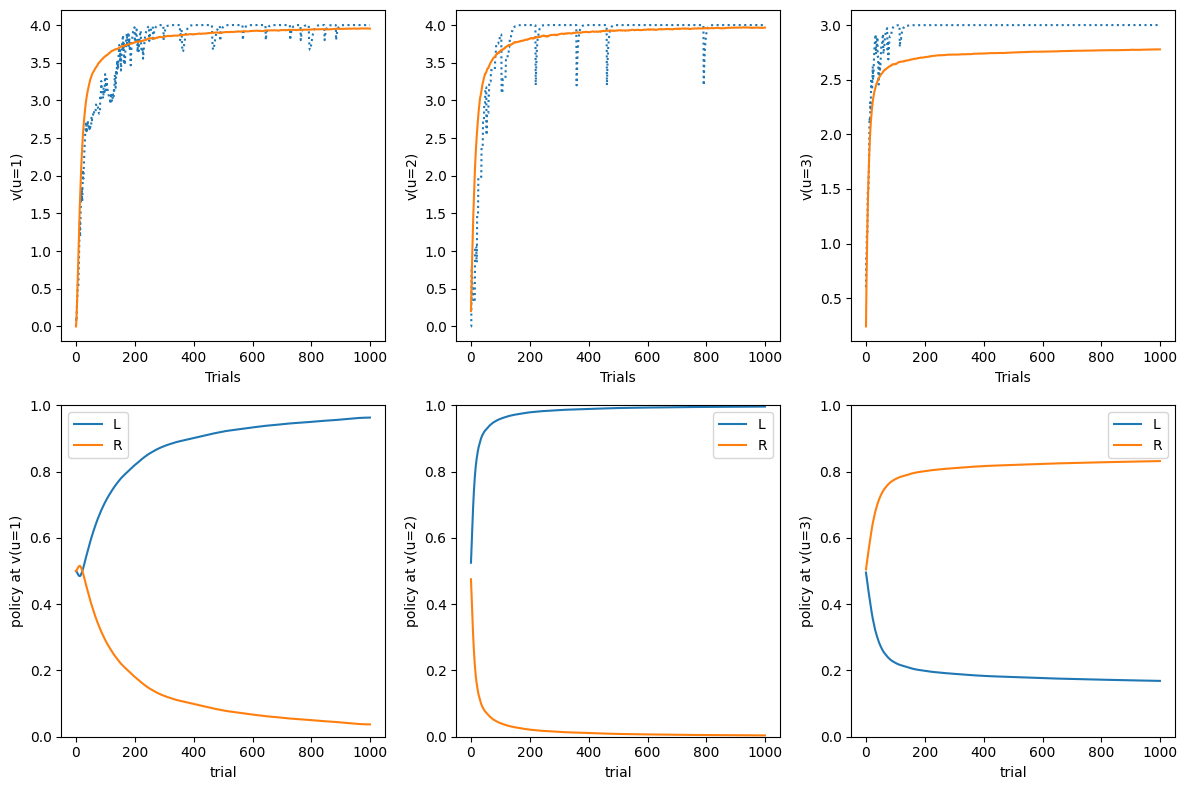

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for action in range(3):
    means = np.mean(v_hist[:, :, action], axis=0)
    
    axs[0, action].plot(range(epochs), v_hist[0, :, action], linestyle='dotted')
    axs[0, action].plot(range(epochs), means, label="Mean")
    #axs[0, action].axhline(y=maxima[action], color='grey', linestyle='dashed')  
    #axs[0, action].axhline(y=average_future_rewards[action], color='grey', linestyle='dotted')

    axs[0, action].set_xlabel("Trials")
    axs[0, action].set_ylabel(f"v(u={action + 1})")

# Plot policies for v(u=1)
mean_policy_over_epochs_1 = np.mean(policy_hist[:, :, :2], axis=0)
axs[1, 0].plot(range(epochs), mean_policy_over_epochs_1[:, 0], label="L")
axs[1, 0].plot(range(epochs), mean_policy_over_epochs_1[:, 1], label="R")
axs[1, 0].set_xlabel("trial")
axs[1, 0].set_ylabel("policy at v(u=1)")
axs[1, 0].set_ylim(0,1)
axs[1, 0].legend()

# Plot policies for v(u=2)
mean_policy_over_epochs_2 = np.mean(policy_hist[:, :, 2:4], axis=0)
axs[1, 1].plot(range(epochs), mean_policy_over_epochs_2[:, 0], label="L")
axs[1, 1].plot(range(epochs), mean_policy_over_epochs_2[:, 1], label="R")
axs[1, 1].set_xlabel("trial")
axs[1, 1].set_ylabel("policy at v(u=2)")
axs[1, 1].set_ylim(0,1)
axs[1, 1].legend()

# Plot policies for v(u=3)
mean_policy_over_epochs_3 = np.mean(policy_hist[:, :, 4:6], axis=0)
axs[1, 2].plot(range(epochs), mean_policy_over_epochs_3[:, 0], label="L")
axs[1, 2].plot(range(epochs), mean_policy_over_epochs_3[:, 1], label="R")
axs[1, 2].set_xlabel("trial")
axs[1, 2].set_ylabel("policy at v(u=3)")
axs[1, 2].set_ylim(0,1)
axs[1, 2].legend()

plt.tight_layout()
plt.show()